In [23]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import linear_model
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, Linear, Sequential, ReLU
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from myresnet import resnet18
from torch.optim import Adam, SGD
# from IPython.display import clear_output

In [57]:
def evaluate(model, data_loader, fft=False, crop=28):
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.cuda(), y.cuda()
            if fft:
                x = torch.fft.fft2(x)
                real = torch.roll(x.real, shifts=(crop // 2, crop // 2), dims=(2, 3))[:, :, :crop, :crop].contiguous().view(-1, crop*crop)
                imag = torch.roll(x.imag, shifts=(crop // 2, crop // 2), dims=(2, 3))[:, :, :crop, :crop].contiguous().view(-1, crop*crop)
                x = torch.cat([real, imag], dim=1)
            yy = model(x)
            total += x.shape[0]
            correct += torch.sum(torch.argmax(yy, dim=1) == y)
    res = float(correct) / total
    print(f"Accuracy: {res*100:0.2f}%")
    return res


In [3]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

train_set = MNIST(os.path.expanduser("~/datasets/mnist"), download=True, train=True, transform=transforms.ToTensor())
test_set = MNIST(os.path.expanduser("~/datasets/mnist"), download=True, train=False, transform=transforms.ToTensor())
print(len(train_set), len(test_set))

train_loader = DataLoader(train_set, batch_size=2048, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=2048, shuffle=False, pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/xc429/datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/xc429/datasets/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/xc429/datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/xc429/datasets/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/xc429/datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/xc429/datasets/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/xc429/datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/xc429/datasets/mnist/MNIST/raw

60000 10000


In [18]:
model = resnet18(pretrained=False).cuda()

criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [21]:
epochs = 10

for epoch in range(1 ,epochs+1):
    print(f"epoch {epoch}")
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        x = torch.fft.fft2(x).imag
        yy = model(x)
        loss = criterion(yy, y)
        loss.backward()
        optimizer.step()

#         bar.display(f"Accuracy: {torch.sum(torch.argmax(yy, dim=1) == y)*100/y.shape[0]:0.2f}%")
#     evaluate(model, train_loader)
    evaluate(model, test_loader)
    scheduler.step()

epoch 1
Accuracy: 13.64%
epoch 2
Accuracy: 16.83%
epoch 3
Accuracy: 16.91%
epoch 4
Accuracy: 16.84%
epoch 5
Accuracy: 16.55%
epoch 6
Accuracy: 16.55%
epoch 7
Accuracy: 16.48%
epoch 8
Accuracy: 16.35%
epoch 9
Accuracy: 16.31%
epoch 10
Accuracy: 16.29%


In [61]:
crop = 20

model = Sequential(Linear(2*crop*crop, 256),
                   ReLU(inplace=True),
                   Linear(256, 256),
                   ReLU(inplace=True),
                   Linear(256, 10)).cuda()

criterion = CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [62]:
epochs = 50

for epoch in range(1 ,epochs+1):
    print(f"epoch {epoch}")
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        x = torch.fft.fft2(x)
        real = torch.roll(x.real, shifts=(crop // 2, crop // 2), dims=(2, 3))[:, :, :crop, :crop].contiguous().view(-1, crop*crop)
        imag = torch.roll(x.imag, shifts=(crop // 2, crop // 2), dims=(2, 3))[:, :, :crop, :crop].contiguous().view(-1, crop*crop)
        x = torch.cat([real, imag], dim=1)
        yy = model(x)
        loss = criterion(yy, y)
        loss.backward()
        optimizer.step()

    evaluate(model, test_loader, fft=True, crop=crop)
    scheduler.step()

epoch 1
Accuracy: 86.22%
epoch 2
Accuracy: 90.77%
epoch 3
Accuracy: 92.93%
epoch 4
Accuracy: 93.85%
epoch 5


KeyboardInterrupt: 

In [65]:
res_dict = []
epochs = 50

for crop in range(1, 29):
    print(f"crop={crop}")
    model = Sequential(Linear(2*crop*crop, 256),
                       ReLU(inplace=True),
                       Linear(256, 256),
                       ReLU(inplace=True),
                       Linear(256, 10)).cuda()

    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    best_res = 0
    cnt = 0
    for epoch in range(1 ,epochs+1):
        print(f"epoch {epoch}")
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()
            x = torch.fft.fft2(x)
            real = torch.roll(x.real, shifts=(crop // 2, crop // 2), dims=(2, 3))[:, :, :crop, :crop].contiguous().view(-1, crop*crop)
            imag = torch.roll(x.imag, shifts=(crop // 2, crop // 2), dims=(2, 3))[:, :, :crop, :crop].contiguous().view(-1, crop*crop)
            x = torch.cat([real, imag], dim=1)
            yy = model(x)
            loss = criterion(yy, y)
            loss.backward()
            optimizer.step()

        res = evaluate(model, test_loader, fft=True, crop=crop)
        if best_res < res:
            best_res = res
            cnt = 0
        else:
            cnt += 1
        if cnt >= 10:
            break
            
        scheduler.step()
    res_dict.append(best_res)

crop=1
epoch 1
Accuracy: 9.33%
epoch 2
Accuracy: 14.65%
epoch 3
Accuracy: 11.35%
epoch 4
Accuracy: 11.35%
epoch 5
Accuracy: 10.28%
epoch 6
Accuracy: 9.58%
epoch 7
Accuracy: 9.80%
epoch 8
Accuracy: 9.80%
epoch 9
Accuracy: 11.35%
epoch 10
Accuracy: 11.35%
epoch 11
Accuracy: 11.35%
epoch 12
Accuracy: 11.35%
crop=2
epoch 1
Accuracy: 37.38%
epoch 2
Accuracy: 45.16%
epoch 3
Accuracy: 55.36%
epoch 4
Accuracy: 58.26%
epoch 5
Accuracy: 48.30%
epoch 6
Accuracy: 46.76%
epoch 7
Accuracy: 21.01%
epoch 8
Accuracy: 21.91%
epoch 9
Accuracy: 18.86%
epoch 10
Accuracy: 15.62%
epoch 11
Accuracy: 17.79%
epoch 12
Accuracy: 17.33%
epoch 13
Accuracy: 18.85%
epoch 14
Accuracy: 20.28%
crop=3
epoch 1
Accuracy: 29.92%
epoch 2
Accuracy: 17.39%
epoch 3
Accuracy: 14.60%
epoch 4
Accuracy: 16.29%
epoch 5
Accuracy: 13.53%
epoch 6
Accuracy: 15.56%
epoch 7
Accuracy: 11.35%
epoch 8
Accuracy: 9.80%
epoch 9
Accuracy: 9.80%
epoch 10
Accuracy: 9.80%
epoch 11
Accuracy: 9.80%
crop=4
epoch 1
Accuracy: 57.43%
epoch 2
Accuracy: 76

Accuracy: 93.29%
epoch 8
Accuracy: 93.85%
epoch 9
Accuracy: 93.34%
epoch 10
Accuracy: 93.48%
epoch 11
Accuracy: 93.50%
epoch 12
Accuracy: 93.47%
epoch 13
Accuracy: 93.80%
epoch 14
Accuracy: 94.17%
epoch 15
Accuracy: 94.81%
epoch 16
Accuracy: 94.90%
epoch 17
Accuracy: 94.88%
epoch 18
Accuracy: 95.04%
epoch 19
Accuracy: 95.16%
epoch 20
Accuracy: 95.19%
epoch 21
Accuracy: 95.31%
epoch 22
Accuracy: 95.32%
epoch 23
Accuracy: 95.27%
epoch 24
Accuracy: 95.33%
epoch 25
Accuracy: 95.34%
epoch 26
Accuracy: 95.39%
epoch 27
Accuracy: 95.37%
epoch 28
Accuracy: 95.37%
epoch 29
Accuracy: 95.47%
epoch 30
Accuracy: 95.53%
epoch 31
Accuracy: 95.56%
epoch 32
Accuracy: 95.56%
epoch 33
Accuracy: 95.58%
epoch 34
Accuracy: 95.59%
epoch 35
Accuracy: 95.65%
epoch 36
Accuracy: 95.65%
epoch 37
Accuracy: 95.64%
epoch 38
Accuracy: 95.63%
epoch 39
Accuracy: 95.64%
epoch 40
Accuracy: 95.64%
epoch 41
Accuracy: 95.64%
epoch 42
Accuracy: 95.64%
epoch 43
Accuracy: 95.64%
epoch 44
Accuracy: 95.64%
epoch 45
Accuracy: 95.6

Accuracy: 95.50%
epoch 38
Accuracy: 95.52%
epoch 39
Accuracy: 95.52%
crop=18
epoch 1
Accuracy: 86.23%
epoch 2
Accuracy: 92.58%
epoch 3
Accuracy: 92.86%
epoch 4
Accuracy: 93.94%
epoch 5
Accuracy: 94.65%
epoch 6
Accuracy: 94.01%
epoch 7
Accuracy: 93.91%
epoch 8
Accuracy: 94.36%
epoch 9
Accuracy: 94.31%
epoch 10
Accuracy: 94.11%
epoch 11
Accuracy: 94.36%
epoch 12
Accuracy: 94.55%
epoch 13
Accuracy: 94.80%
epoch 14
Accuracy: 94.37%
epoch 15
Accuracy: 94.61%
epoch 16
Accuracy: 94.89%
epoch 17
Accuracy: 95.18%
epoch 18
Accuracy: 95.49%
epoch 19
Accuracy: 95.57%
epoch 20
Accuracy: 95.36%
epoch 21
Accuracy: 95.41%
epoch 22
Accuracy: 95.43%
epoch 23
Accuracy: 95.49%
epoch 24
Accuracy: 95.43%
epoch 25
Accuracy: 95.51%
epoch 26
Accuracy: 95.55%
epoch 27
Accuracy: 95.62%
epoch 28
Accuracy: 95.68%
epoch 29
Accuracy: 95.67%
epoch 30
Accuracy: 95.66%
epoch 31
Accuracy: 95.69%
epoch 32
Accuracy: 95.70%
epoch 33
Accuracy: 95.69%
epoch 34
Accuracy: 95.74%
epoch 35
Accuracy: 95.73%
epoch 36
Accuracy: 95.

Accuracy: 95.47%
epoch 37
Accuracy: 95.44%
epoch 38
Accuracy: 95.46%
epoch 39
Accuracy: 95.42%
epoch 40
Accuracy: 95.47%
epoch 41
Accuracy: 95.48%
epoch 42
Accuracy: 95.47%
epoch 43
Accuracy: 95.48%
epoch 44
Accuracy: 95.50%
crop=25
epoch 1
Accuracy: 78.46%
epoch 2
Accuracy: 91.69%
epoch 3
Accuracy: 93.51%
epoch 4
Accuracy: 93.82%
epoch 5
Accuracy: 94.34%
epoch 6
Accuracy: 94.24%
epoch 7
Accuracy: 94.65%
epoch 8
Accuracy: 94.50%
epoch 9
Accuracy: 94.38%
epoch 10
Accuracy: 94.59%
epoch 11
Accuracy: 95.16%
epoch 12
Accuracy: 95.27%
epoch 13
Accuracy: 95.43%
epoch 14
Accuracy: 95.37%
epoch 15
Accuracy: 95.33%
epoch 16
Accuracy: 95.35%
epoch 17
Accuracy: 95.31%
epoch 18
Accuracy: 95.69%
epoch 19
Accuracy: 95.79%
epoch 20
Accuracy: 95.58%
epoch 21
Accuracy: 95.68%
epoch 22
Accuracy: 95.85%
epoch 23
Accuracy: 95.91%
epoch 24
Accuracy: 95.86%
epoch 25
Accuracy: 95.97%
epoch 26
Accuracy: 95.92%
epoch 27
Accuracy: 95.86%
epoch 28
Accuracy: 95.85%
epoch 29
Accuracy: 95.83%
epoch 30
Accuracy: 95.

([<matplotlib.axis.XTick at 0x7f2d0c5719d0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

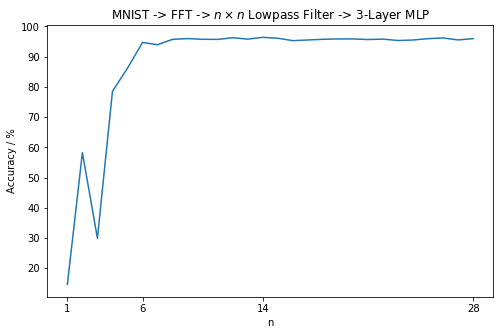

In [69]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 29), np.array(res_dict)*100)
plt.title(r"MNIST -> FFT -> $n\times n$ Lowpass Filter -> 3-Layer MLP")
plt.xlabel("n")
plt.ylabel("Accuracy / %")
plt.xticks([1, 6, 14, 28])

In [4]:
train_set[0][0].shape

torch.Size([1, 28, 28])

In [13]:
torch.fft.fft2(train_set[0][0])

tensor([[[ 1.0794e+02+0.0000e+00j, -7.0843e+01-4.8809e+00j,
           1.6083e+01-6.3485e-01j,  8.8337e-01+3.3025e+00j,
          -3.8229e+00-3.3271e-01j,  7.1165e+00-3.4703e+00j,
          -4.0094e+00+7.7575e+00j,  1.9647e+00-5.4275e+00j,
          -1.6431e+00-3.0681e-01j, -5.2926e-01-1.5568e-01j,
           1.0791e+00+1.4228e+00j, -1.5008e-01+1.8004e-01j,
          -8.3599e-01-1.2102e+00j,  1.8242e+00+1.3187e+00j,
          -2.1765e+00+0.0000e+00j,  1.8242e+00-1.3187e+00j,
          -8.3599e-01+1.2102e+00j, -1.5008e-01-1.8004e-01j,
           1.0791e+00-1.4228e+00j, -5.2926e-01+1.5568e-01j,
          -1.6431e+00+3.0681e-01j,  1.9647e+00+5.4275e+00j,
          -4.0094e+00-7.7575e+00j,  7.1165e+00+3.4703e+00j,
          -3.8229e+00+3.3271e-01j,  8.8337e-01-3.3025e+00j,
           1.6083e+01+6.3485e-01j, -7.0843e+01+4.8809e+00j],
         [-1.8678e+01-2.2314e+00j,  3.0404e+01-6.5218e+00j,
          -1.0065e+01+5.8272e+00j, -1.0305e+01-2.2740e+00j,
           2.7064e+00-3.6742e+00j,  2.2

Text(0.5, 1.0, 'imaginary')

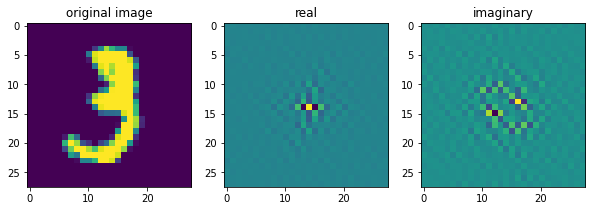

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(10, 6))
t = train_set[10][0].view(1, 1, 28, 28)
ax[0].imshow(t[0, 0])
ax[0].set_title("original image")
f0 = torch.fft.fft2(t)
f1 = torch.roll(f0.real, shifts=(14, 14), dims=(2, 3))
f2 = torch.roll(f0.imag, shifts=(14, 14), dims=(2, 3))
ax[1].imshow(f1[0, 0])
ax[1].set_title("real")
ax[2].imshow(f2[0, 0])
ax[2].set_title("imaginary")